# Proyecto 2 - Coronavirus

Este proyecto consiste en estimar un modelo SIR con datos de un país sobre el COVID-19.

In [1]:
# Carga de librerías
import pandas as pd
import numpy as np
from scipy import integrate
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error, median_absolute_error
from scipy.integrate import odeint
from scipy.optimize import differential_evolution, minimize
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Toolbox especial
import PDEparams as pde
# https://github.com/systemsmedicine/PDE_params

### Carga de Datos (Rusia)

De acuerdo a Google, la población de Rusia es

$$
N = 144.5 \text{ Millones}
$$

In [3]:
# Vamos a considerar la población mundial de Rusia
N = 144500000
# Estos son todos los datos con los que contamos
data = pd.read_csv('Russia_COVID.csv')
data.head()

,Fecha,Tiempo,Infectados_Acumulados,Recuperados_Acumulados,Muertes_Acumulados,Infectados,Recuperados,Muertos
0,1/22/20,1,0,0,0,0,0,0
1,1/23/20,2,0,0,0,0,0,0
2,1/24/20,3,0,0,0,0,0,0
3,1/25/20,4,0,0,0,0,0,0
4,1/26/20,5,0,0,0,0,0,0


## Defininimos el modelo SIR

$$\begin{align}
\frac{\mathrm{d} S}{\mathrm{d} t} &= -\beta\, \frac{SI}{N}\\
\frac{\mathrm{d} I}{\mathrm{d} t} &= \beta\, \frac{SI}{N} - \gamma\,I\\
\frac{\mathrm{d} R}{\mathrm{d} t} &= \gamma\,I
\end{align}$$

Susceptible -> Infectado -> Recuperado

$$
\begin{align}
\beta &= \text{Tasa de contacto } \times \text{Probabilidad de Transmisión}\\
\gamma &= \text{Tasa de Recuperación}
\end{align}
$$

En particular, nosotros vamos a considerar:

- $S :=$ Población susceptible.

- $I :=$ Población Infectada.

- $R :=$ Población Recuperada

Nota: Este modelo asumirá que $R$ es la población que no que fue infectada pero ya no puede volver a infectar. Por efectos de cómo tenemos los datos, nosotros vamos a considerar que estos serán los muertos más los recuperados.

In [4]:
# En realidad nosotros vamos a ocupar lo siguiente
datos = pd.DataFrame({
            # Tiempo
            't': data.Tiempo,
            # Susceptibles
            'S': N - np.cumsum(data.Infectados) -  (np.cumsum(data.Recuperados) + np.cumsum(data.Muertos)),
            # Infectados
            'I': data.Infectados,
            # Recuperados (este modelo asume que los recuperados son las personas que ya no pueden contagiar)
            'R': data.Muertos + data.Recuperados 
})
datos.describe()

,t,S,I,R
count,321.000000,3.210000e+02,321.000000,321.000000
mean,161.000000,1.432630e+08,7685.236760,6176.059190
std,92.808944,1.205129e+06,7110.665979,6528.110415
min,1.000000,1.400505e+08,0.000000,0.000000
25%,81.000000,1.424955e+08,1786.000000,197.000000
50%,161.000000,1.434318e+08,6096.000000,5478.000000
75%,241.000000,1.444853e+08,9623.000000,8776.000000
max,321.000000,1.445000e+08,28701.000000,29627.000000


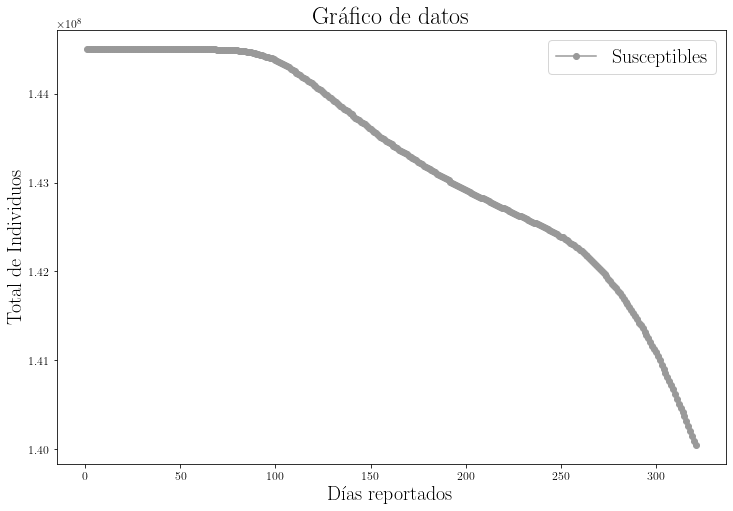

In [5]:
plt.figure(figsize=(12, 8))
plt.title("Gráfico de datos")
plt.plot(datos.t, datos.S, '-o', label="Susceptibles")
plt.ylabel("Total de Individuos")
plt.xlabel("Días reportados")
plt.legend()

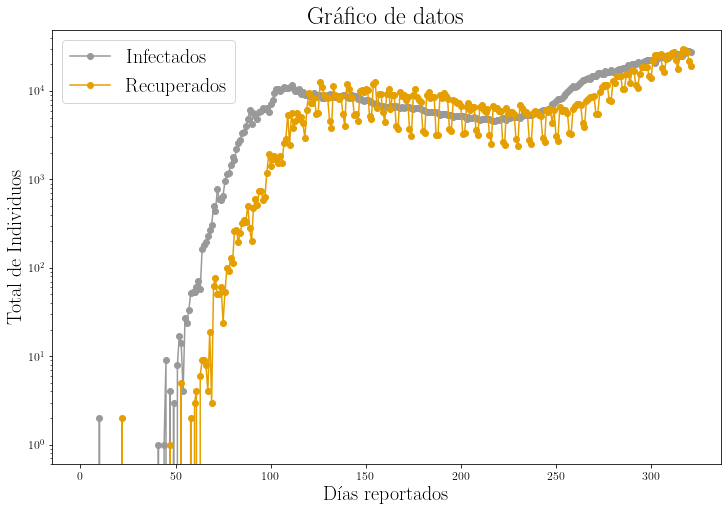

In [6]:
plt.figure(figsize=(12, 8))
plt.title("Gráfico de datos")
plt.plot(datos.t, datos.I, '-o', label="Infectados")
plt.plot(datos.t, datos.R, '-o', label="Recuperados")
plt.yscale('log')
plt.ylabel("Total de Individuos")
plt.xlabel("Días reportados")
plt.legend()

Definimos el sistema de ecuaciones diferenciales a resolver

In [7]:
def sistema_SIR(z, t, beta, gamma):
    
    S, I, R = z
    
    # dS/dt
    dSdt = - beta * S * I / N 
    # dI/dt
    dIdt = beta * S * I / N - gamma * I
    # dR/dt
    dRdt = gamma * I

    
    return [dSdt,dIdt,dRdt]

Vamos a definir los valores iniciales de nuestros datos. Para esto, consideramos un escenario donde al principio teníamos un infectado, ningún recuperado y una población susceptible de $N-1$.

In [8]:
# Susceptible inicial
def S0():
    return N-1
# Infectado inicial
def I0():
    return 1
# Recuperado inicial
def R0():
    return 0

Con base en todo lo anterior, ejectuamos nuestro modelo

In [9]:
modelo_SIR = pde.PDEmodel(datos, sistema_SIR, [S0,I0,R0], bounds=[(0, 10), (0,10)], 
                        param_names=[r'$\beta$', r'$\gamma$'], nvars=3, ndims=0, nreplicates=1, obsidx=None, outfunc=None)

In [10]:
# Mostramos la condición Inicial
modelo_SIR.initial_condition

array([144499999,         1,         0])

##### Encontrando los mejores parámetros

In [11]:
%%time
modelo_SIR.fit()

   $\beta$  $\gamma$
0  8.73236  8.687238
Wall time: 2.9 s


In [12]:
modelo_SIR.best_params

,$\beta$,$\gamma$
0,8.73236,8.687238


In [13]:
modelo_SIR.best_error

522393194903.81177

#### Likelihood profiles

In [14]:
%%time
modelo_SIR.likelihood_profiles(npoints=50)



Wall time: 1min 34s


In [15]:
modelo_SIR.result_profiles

,parameter,value,error
0,$\beta$,0.000000,9.927122e+11
1,$\beta$,0.204082,9.927043e+11
2,$\beta$,0.408163,9.924885e+11
3,$\beta$,0.612245,9.926991e+11
4,$\beta$,0.816327,6.373795e+11
...,...,...,...
95,$\gamma$,9.183673,9.920978e+11
96,$\gamma$,9.387755,5.228857e+11
97,$\gamma$,9.591837,9.747688e+11
98,$\gamma$,9.795918,5.235795e+11


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


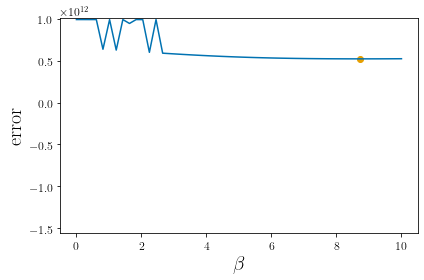

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


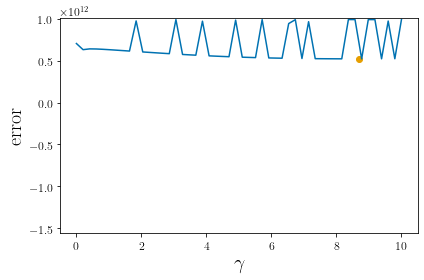

In [16]:
modelo_SIR.plot_profiles()

## Defininimos el modelo SIRD

$$\begin{align}
\frac{\mathrm{d} S}{\mathrm{d} t} &= -\beta\, \frac{SI}{N}\\
\frac{\mathrm{d} I}{\mathrm{d} t} &= \beta\, \frac{SI}{N} - \gamma I - \mu I\\
\frac{\mathrm{d} R}{\mathrm{d} t} &= \gamma\,I\\
\frac{\mathrm{d} D}{\mathrm{d} t} &= \mu\,I
\end{align}$$

$$
\begin{align}
\beta &= \text{Tasa de contacto } \times \text{Probabilidad de Transmisión}\\
\gamma &= \text{Tasa de Recuperación}\\
\mu &= \text{Tasa de Mortalidad}
\end{align}
$$

En particular, nosotros vamos a considerar:

- $S :=$ Población susceptible.

- $I :=$ Población Infectada.

- $R :=$ Población Recuperada

- $D :=$ Población Muerta

In [17]:
# En realidad nosotros vamos a ocupar lo siguiente
datos = pd.DataFrame({
            # Tiempo
            't': data.Tiempo,
            # Susceptibles
            'S': N - np.cumsum(data.Infectados) - (np.cumsum(data.Recuperados) + np.cumsum(data.Muertos)),
            # Infectados
            'I': data.Infectados,
            # Recuperados
            'R': data.Recuperados,
            # Muertos
            'D': data.Muertos
})
datos.describe()

,t,S,I,R,D
count,321.000000,3.210000e+02,321.000000,321.000000,321.000000
mean,161.000000,1.432630e+08,7685.236760,6041.722741,134.336449
std,92.808944,1.205129e+06,7110.665979,6401.488399,130.640868
min,1.000000,1.400505e+08,0.000000,0.000000,0.000000
25%,81.000000,1.424955e+08,1786.000000,155.000000,18.000000
50%,161.000000,1.434318e+08,6096.000000,5352.000000,114.000000
75%,241.000000,1.444853e+08,9623.000000,8499.000000,175.000000
max,321.000000,1.445000e+08,28701.000000,29084.000000,580.000000


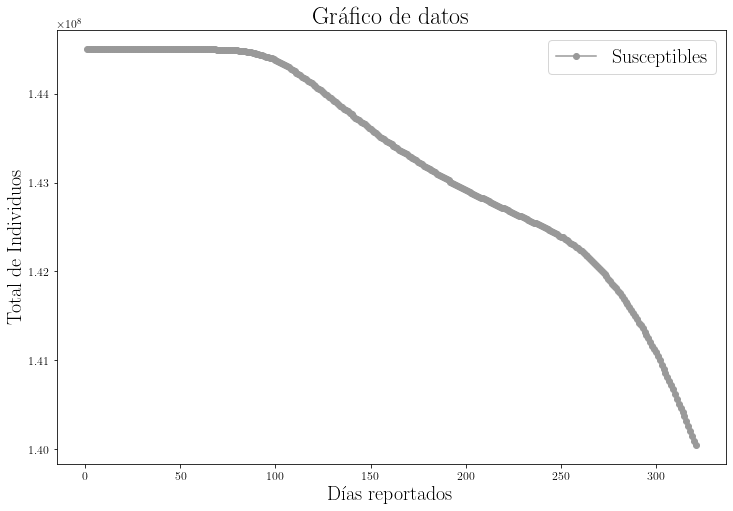

In [18]:
plt.figure(figsize=(12, 8))
plt.title("Gráfico de datos")
plt.plot(datos.t, datos.S, '-o', label="Susceptibles")
plt.ylabel("Total de Individuos")
plt.xlabel("Días reportados")
plt.legend()

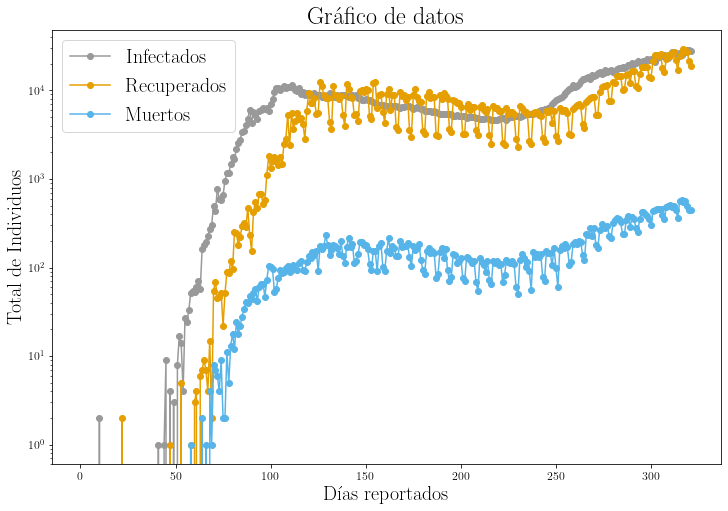

In [19]:
plt.figure(figsize=(12, 8))
plt.title("Gráfico de datos")
plt.plot(datos.t, datos.I, '-o', label="Infectados")
plt.plot(datos.t, datos.R, '-o', label="Recuperados")
plt.plot(datos.t, datos.D, '-o', label="Muertos")
plt.yscale('log')
plt.ylabel("Total de Individuos")
plt.xlabel("Días reportados")
plt.legend()

Definimos el sistema de ecuaciones diferenciales a resolver

In [20]:
def sistema_SIR(z, t, beta, gamma,mu):
    
    S, I, R, D = z
    
    # dS/dt
    dSdt = - beta * S * I / N 
    # dI/dt
    dIdt = beta * S * I / N - gamma * I - mu * D
    # dR/dt
    dRdt = gamma * I
    # dD/dt
    dDdt = mu * D
    
    return [dSdt,dIdt,dRdt,dDdt]

Vamos a definir los valores iniciales de nuestros datos. Para esto, consideramos un escenario donde al principio teníamos un infectado, ningún recuperado, ningún muerto y una población susceptible de $N-1$.

In [21]:
# Susceptible inicial
def S0():
    return N-1
# Infectado inicial
def I0():
    return 1
# Recuperado inicial
def R0():
    return 0
# Muerto inicial
def D0():
    return 0

Con base en todo lo anterior, ejectuamos nuestro modelo

In [22]:
modelo_SIRD = pde.PDEmodel(datos, sistema_SIR, [S0,I0,R0,D0], bounds=[(0, 10), (0,10), (0,10)], 
                        param_names=[r'$\beta$', r'$\gamma$', r'$\mu$'], nvars=4, ndims=0, nreplicates=1, obsidx=None, outfunc=None)

In [23]:
# Mostramos la condición Inicial
modelo_SIRD.initial_condition

array([144499999,         1,         0,         0])

##### Encontrando los mejores parámetros

In [24]:
%%time
modelo_SIRD.fit()

    $\beta$  $\gamma$     $\mu$
0  8.964491  8.919054  1.149126
Wall time: 4.24 s


In [25]:
modelo_SIRD.best_params

,$\beta$,$\gamma$,$\mu$
0,8.964491,8.919054,1.149126


In [26]:
modelo_SIRD.best_error

391895996780.9392

#### Likelihood profiles

In [27]:
%%time
modelo_SIRD.likelihood_profiles(npoints=50)



Wall time: 4min 54s


In [28]:
modelo_SIRD.result_profiles

,parameter,value,error
0,$\beta$,0.000000,7.445334e+11
1,$\beta$,0.204082,7.428601e+11
2,$\beta$,0.408163,7.445311e+11
3,$\beta$,0.612245,7.445171e+11
4,$\beta$,0.816327,4.780901e+11
...,...,...,...
145,$\mu$,9.183673,3.918828e+11
146,$\mu$,9.387755,3.918574e+11
147,$\mu$,9.591837,3.919110e+11
148,$\mu$,9.795918,7.429414e+11


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


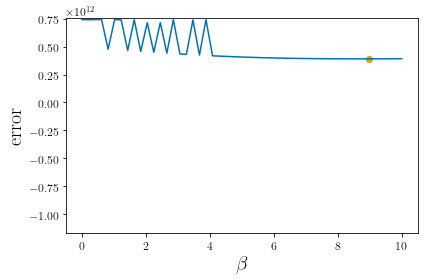

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


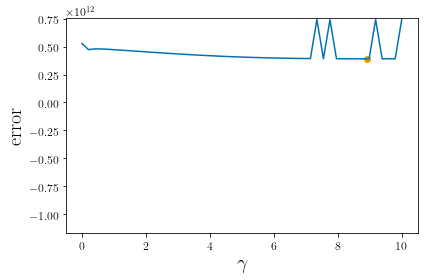

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


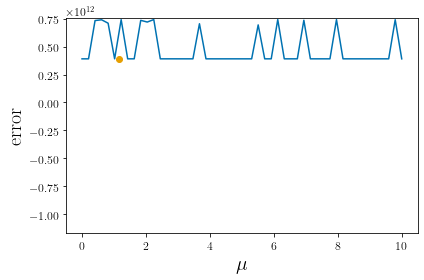

In [29]:
modelo_SIRD.plot_profiles()

### Fuentes
- https://data.humdata.org/dataset/novel-coronavirus-2019-ncov-cases?force_layout=desktop

- https://www.google.com/search?q=poblacion+total+de+rusia&rlz=1C1CHBF_esMX925MX926&oq=poblacion+total+de+rusia&aqs=chrome..69i57j0j0i22i30l6.3610j0j7&sourceid=chrome&ie=UTF-8

- https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIRD_model